# Bitcoin Price Prediction

Bitcoin is a digital currency that was created in January 2009. Bitcoin is a type of cryptocurrency. There are no physical bitcoins, only balances kept on a public ledger that everyone has transparent access to. All bitcoin transactions are verified by a massive amount of computing power. Bitcoins are not issued or backed by any banks or governments, nor are individual bitcoins.<br>
<t>The bitcoin system is a collection of computers (also referred to as "nodes" or "miners") that all run bitcoin's code and store its blockchain. Metaphorically, a blockchain can be thought of as a collection of blocks. In each block is a collection of transactions. Because all the computers running the blockchain has the same list of blocks and transactions, and can transparently see these new blocks being filled with new bitcoin transactions, no one can cheat the system.
<br>
Anyone, whether they run a bitcoin "node" or not, can see these transactions occurring live. In order to achieve a nefarious act, a bad actor would need to operate 51% of the computing power that makes up bitcoin. Bitcoin has around 12,000 nodes, as of January 2021, and this number is growing.

So we will view the market trends and wheather its still worth it to invest in it?

In [10]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [19]:
#importing libs
import pandas as pd 
import numpy as np
from datetime import datetime
import requests
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score,mean_squared_error
import warnings
warnings.filterwarnings('ignore')

We have the kaggle dataset ,can be found [here](https://www.kaggle.com/mczielinski/bitcoin-historical-data).


In [2]:
data=pd.read_csv('bitcoin_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


From above we can see that their are many null values, so let's check how many null values are their:

### Data cleaning 

In [9]:
for col in data.columns:                
    print("Number of null values in col ",col," is: ",data[col].isnull().sum()) ## checking total null values in each col

    
print("\n\n",data.columns)

Number of null values in col  Timestamp  is:  0
Number of null values in col  Open  is:  1243608
Number of null values in col  High  is:  1243608
Number of null values in col  Low  is:  1243608
Number of null values in col  Close  is:  1243608
Number of null values in col  Volume_(BTC)  is:  1243608
Number of null values in col  Volume_(Currency)  is:  1243608
Number of null values in col  Weighted_Price  is:  1243608


 Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price'],
      dtype='object')


The total null values in each column is 1243608. <br>
It might be the case that each col have null values at different indexes , i.e. we need to check that whether whole row is null or these null values are from different cells. <br>

I am using concept of masking , which generate a bool value for the index places that are null.
Ex. : 

|Open|High|
|---|---|
|4.39|4.39|
|nan|nan|
|nan|nan|
|58714.31|58714.31|
|...|...|

The masking for each col would be like:
* Open: [false,true,true,false,...]
* High: [false,true,true,false,...]

Then we will take `and` operation of all these col values , after masking all of them we would get the the bool mask which contains `true` value which shows row having all col value `null`.

=> Open & High : [false,true,true,false,...]


In [14]:
m1=data.Open.isnull() #bool value for null value for Open col
for col in data.columns[2:]: # iterate over the col and find mask 
    m2=data[col].isnull()
    m1=m1&m2        # take 'and' operator for bool mask columns

print(m1.sum())

0          False
1           True
2           True
3           True
4           True
           ...  
4857372    False
4857373    False
4857374    False
4857375    False
4857376    False
Name: High, Length: 4857377, dtype: bool

The total null rows is 1243608 and if we observe from above the total null values in each col is also 1243608 , this shows that these are the null rows only . And total null values are 4857377, so the missing rows are just 1/4th of total values. 

### Missing values

In [21]:
nn_df=data[data.Open.isnull()] ##getting the null rows

In [22]:
index=nn_df.index   ##getting the index value of null rows 

In [23]:
nn_df['dates'] = nn_df['Timestamp'].apply(lambda d: datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))

In [24]:
nn_df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,dates
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
5,1325318220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
...,...,...,...,...,...,...,...,...,...
4856245,1617080940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-30
4856308,1617084720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-30
4856376,1617088800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-30
4857340,1617146640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-31


Their are many null values :
- if we fill those with 0 then we cannot find proper trend for those missing values.
- if we fill them with mean values, then it might be the case that their are many high values and less values so we might see the drastic change while seeing trend among them because those are 1/4th of the total values.

So , we need to find from where the data has been collected from . While searching for it i found this [link](https://stackoverflow.com/questions/29425894/scraping-data-from-bitcoincharts), but if one used to find the data from that link for the dates we get for null rows , then you get no values for those particular dates , this might shows that data for those values has not been recorded or available.<br>
I tried to find from the dataset has been collected from ,then i found in the description of kaggle dataset that data has been collected from [bitcoincharts](
https://bitcoincharts.com/charts).

I have write another `extract.ipynb` notebook to extract data from the above site using Selenium. 

In [27]:
uniq_dates=list(nn_df['dates'].unique()) ##getting list of dates for null rows

3131

In [22]:
data.iloc[index[-1]]

Timestamp            1.617148e+09
Open                          NaN
High                          NaN
Low                           NaN
Close                         NaN
Volume_(BTC)                  NaN
Volume_(Currency)             NaN
Weighted_Price                NaN
Name: 4857368, dtype: float64

### Merge Scraped Data

From the above scrapped notebook , the data has been stored in `bitcoinunix.csv` .

In [28]:
scrapdata=pd.read_csv('bitcoin_data.csv',index_col=[0]) ## reading scrapped data.

In [29]:
scrapdata

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496


In [30]:
scrapdata.isna().sum()    #checking wheather their is any null value or not

Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

In [31]:
df=data.append(scrapdata,ignore_index=True)  ## appending the scrapped data with the previous data

In [32]:
df.dropna(inplace=True) #dropping null values that comes with previous data

In [33]:
df.sort_values(by="Timestamp")

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1.325318e+09,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,1.325347e+09,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,1.325351e+09,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,1.325351e+09,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,1.325391e+09,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000
...,...,...,...,...,...,...,...,...
4857372,1.617149e+09,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1.617149e+09,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1.617149e+09,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1.617149e+09,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [34]:
df.sort_values('Timestamp',ignore_index=True,inplace=True)

In [ ]:
df.to_csv("bitcoindata.csv", index = False)

After appending the scrapped data, we need to sort the data according to `unix` time.

### Data exploration

In [37]:
df['timestamp'] = pd.to_datetime(df['Timestamp'],unit='s') #converting the unix time to readable format

In [38]:
#abstracting year and month from the readable time format
df['year'] = df['timestamp'].dt.year
# df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
# df['minute'] = df['timestamp'].dt.strftime('%M')
# df['hours'] = df['timestamp'].dt.strftime('%H')
df['date'] = df['timestamp'].dt.strftime('%Y-%m-%d')
# df['seconds']=df['timestamp'].dt.strftime('%S')

In [41]:
df.index = df.timestamp  ## changing the index values according to timestamp

We need to do the timeseries analysis and their are many values , we will use the resample the given datapoints on the basis of `month`. For more details check [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html)

In [43]:
df_month = df.resample('M').mean()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,year,month
timestamp,,,,,,,,,,
2011-12-31,1.325342e+09,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603,2011.0,12.0
2012-01-31,1.326819e+09,6.345389,6.348982,6.341218,6.346148,4.031777,25.168238,6.345955,2012.0,1.0
2012-02-29,1.329314e+09,5.230208,5.231646,5.227036,5.228510,8.313993,42.239422,5.228443,2012.0,2.0
2012-03-31,1.331914e+09,4.985481,4.986695,4.982580,4.983828,15.197791,76.509751,4.984397,2012.0,3.0
2012-04-30,1.334606e+09,4.995171,4.996447,4.993763,4.995079,21.683913,108.218094,4.995091,2012.0,4.0
...,...,...,...,...,...,...,...,...,...,...
2020-11-30,1.605487e+09,16535.778528,16545.663704,16525.571002,16536.023486,6.695166,111021.991229,16535.990325,2020.0,11.0
2020-12-31,1.608120e+09,21811.751812,21826.119052,21796.889787,21812.155606,5.742400,129237.684380,21811.782847,2020.0,12.0
2021-01-31,1.610798e+09,34554.125793,34594.169353,34512.497779,34554.252479,10.253061,352510.183906,34552.337249,2021.0,1.0


We will look at the trend that how the `volume` and `price` of bitcoin has been varied from year 2011 onwards.

### Data visualization

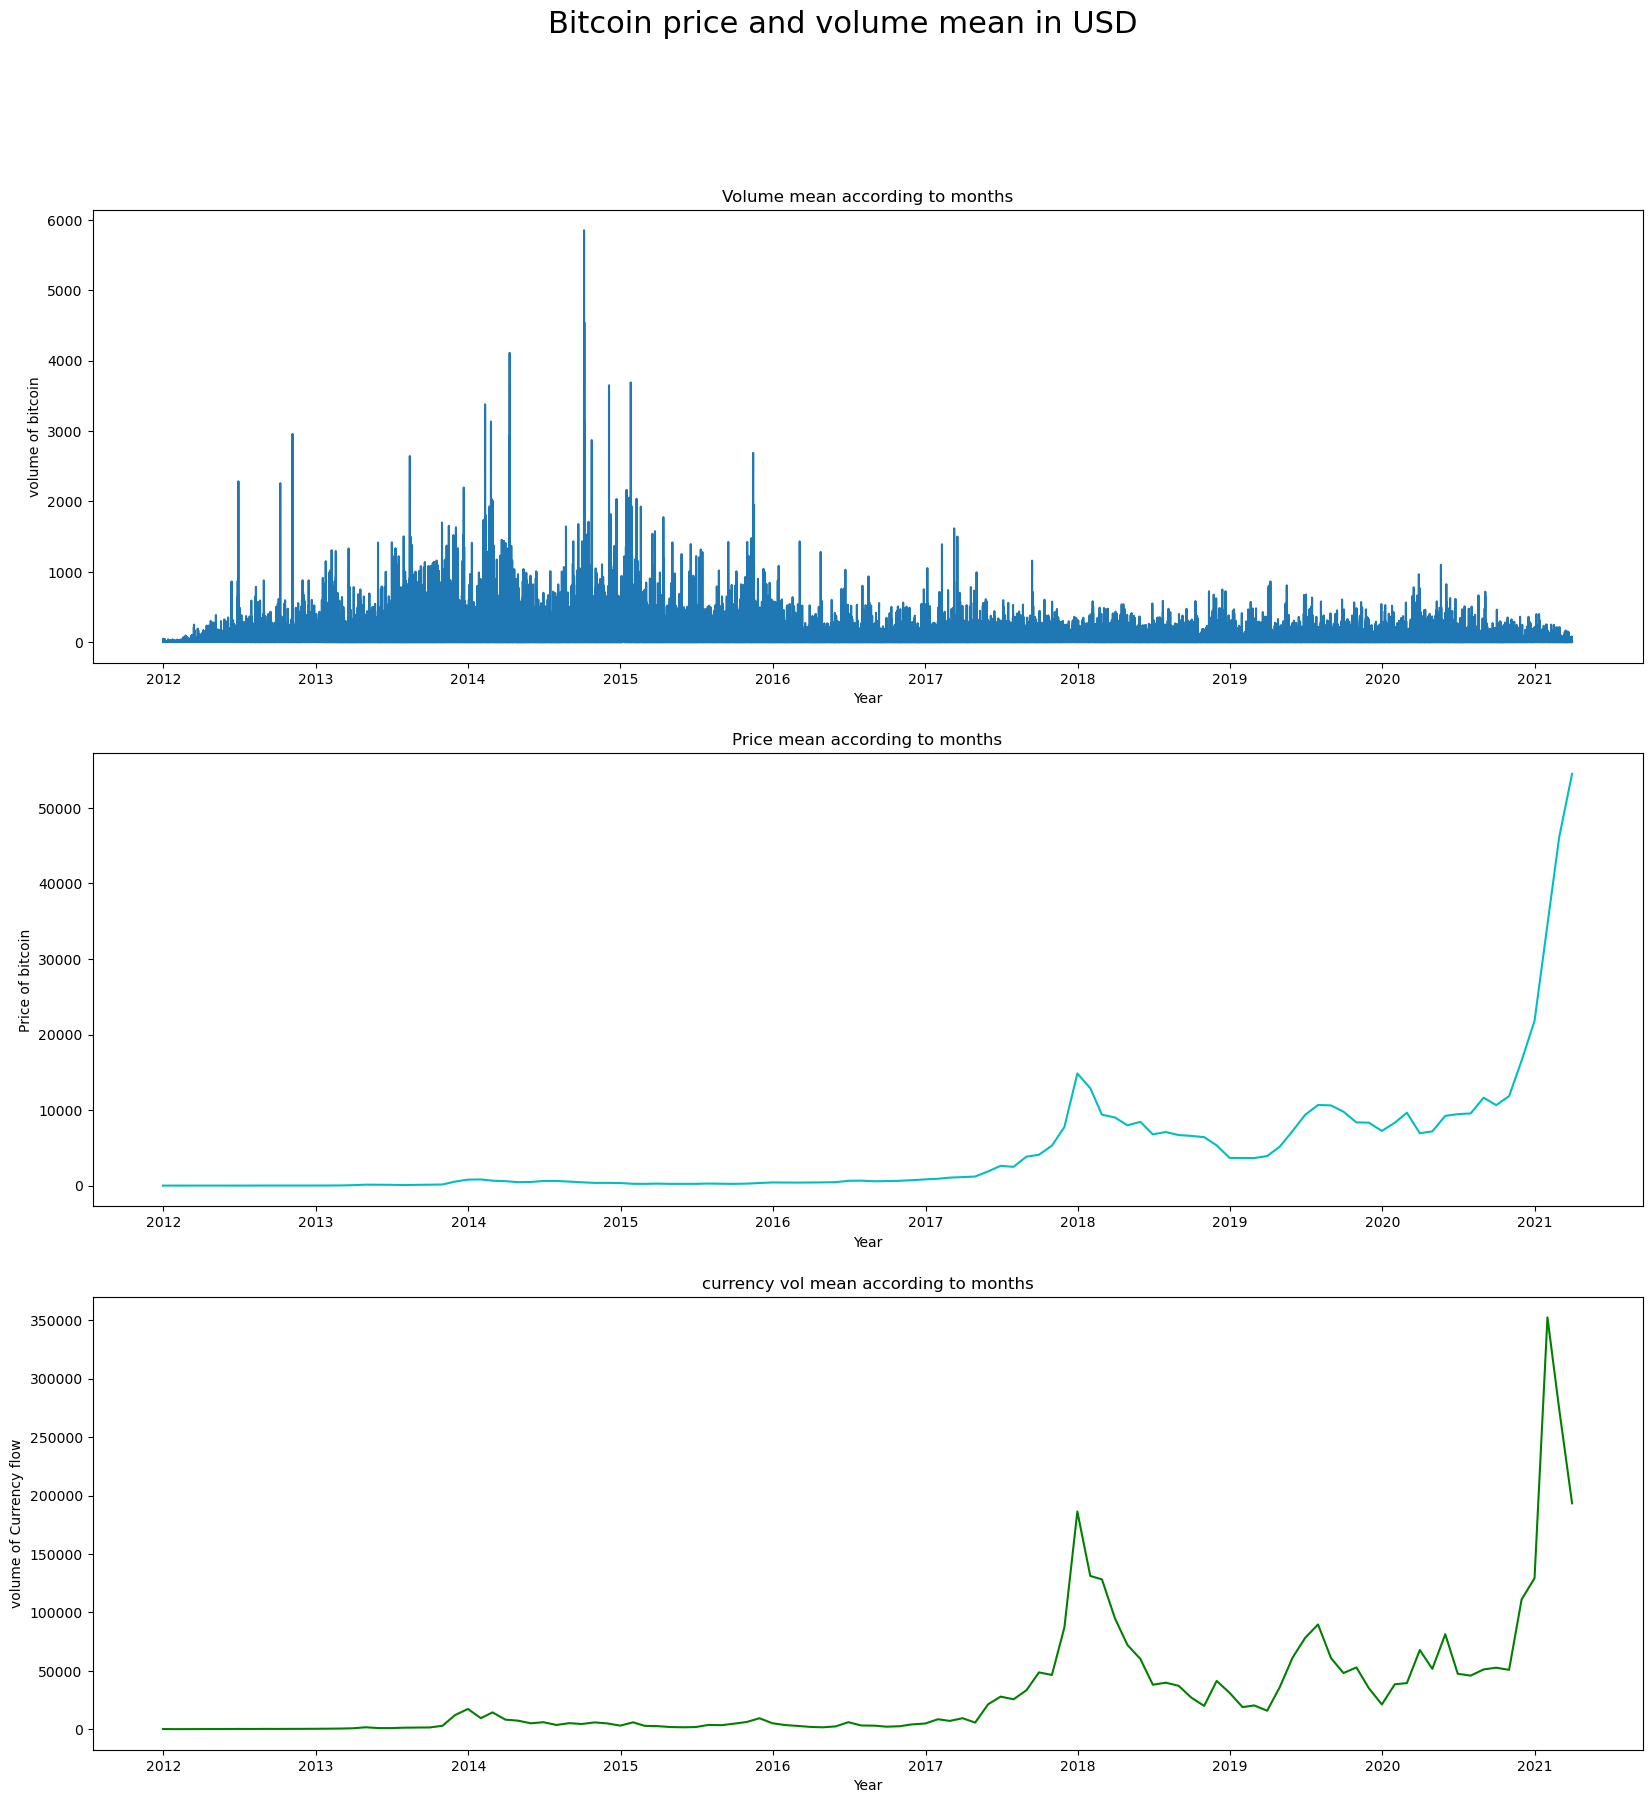

In [44]:
# PLOTS
fig = plt.figure(figsize=[20, 20])
plt.suptitle('Bitcoin price and volume mean in USD', fontsize=22)
##plot for mean volume vs months
plt.subplot(311) ## position of plot 
plt.plot(df['Volume_(BTC)'], '-', label='By Months')  ## plot for volume 
plt.xlabel("Year")
plt.ylabel("volume of bitcoin")
plt.title("Volume mean according to months")

##plot for mean Price vs months
plt.subplot(312)
plt.plot(df_month.Weighted_Price, '-', label='By Months',color='c')    ## plot for the prices
plt.title("Price mean according to months")
plt.xlabel("Year")
plt.ylabel("Price of bitcoin")

##plot for mean currency volume vs months
plt.subplot(313)
plt.plot(df_month['Volume_(Currency)'], '-', label='By Months',color='g')
plt.title("currency vol mean according to months")
plt.xlabel("Year")
plt.ylabel("volume of Currency flow")

plt.show()

- From above we can say that in the starting years till 2015-16 the volume of the bitcoin in the market has been increases but it goes down after it.<br>
Bitcoin is decentralised and as more people come into mining, the price would be increased. Bitcoin releases a block in every 4 years which contains details regarding all the transactions, but volume of bitcoin would be decreases in the future, for more details look after the blockchain.
- From 2nd graph we can clearly say that prices are increases year by year, and we have some peak values in 2018 and 2021, the last block was released 2020 , it might be the case that more people have found this for better investing as its continuosly increasing year by year , thus more money flow hence more inflation. One can look more details for by looking demand and supply trend. And this is same for 3rd plot also.

As the price is increasing very often in recent years so can we say is it still safe for trading ?

Text(0, 0.5, 'prices difference')

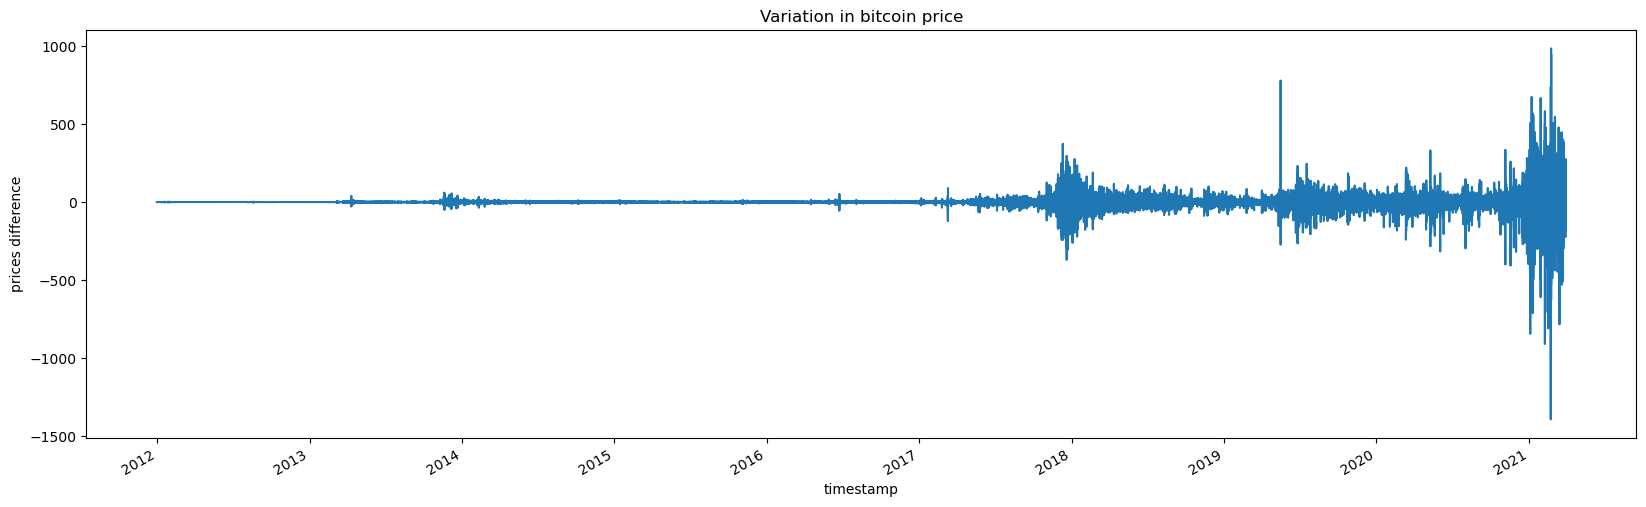

In [45]:
price_diff = df["Weighted_Price"].diff()        ##finding the difference of price for each row
ax=price_diff.plot(figsize=(20,6),title='Variation in bitcoin price')
ax.set_ylabel("prices difference")

If we compare the above plot and previous price trend plot ,then we can say that as the market price for the bitcoin has been increased ,then similarly the variation between the prices also increases i.e. as the price is increasing frequently then the falling of price is also their in the same proportion.

<AxesSubplot:title={'center':'Volume_(BTC)'}, xlabel='year'>

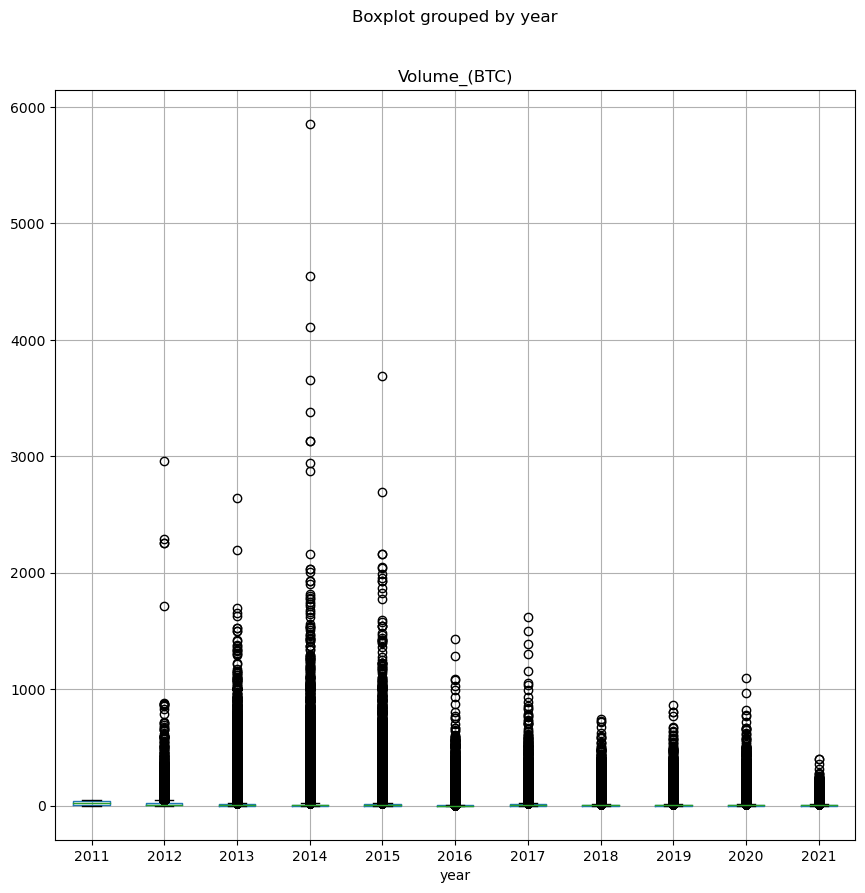

In [46]:
df.boxplot(column='Volume_(BTC)',by = 'year', figsize=(10,10))

This shows that year 2014 has the highest volume for bitcoins in the market and after that the volume has been continously decreasing,althoug the avg volume was very less. One need to look at the market cap for future if wants to trade this in future because the price is definitely increasing but the volume is continuously decreasing ,investor needs to think whether he would be able to trade in this in future or not......

In [ ]:
df.boxplot(column='Volume_(Currency)',by = 'year', figsize=(10,10))

The highest volume trades were made in 2021, avg. currency volume is still very less , this shows that many of the invetors were average investors who wants to do safe trading or they might have the fear of losses, and highest trade volume is very high ,they might be big investor who have the market knowledge or well experience with cypto trading.  

As their is drastic change in recent year, let's see changes over it....

In [ ]:
yeardata=df[df.year>=2020]

In [ ]:
##plot for price variation in year 2020-21
plt.figure(figsize=(20,15))
ax=yeardata[yeardata.year==2020].plot(kind='scatter', x='month', y='High',color = 'cyan',label='2020')
yeardata[yeardata.year==2021].plot(kind='scatter', x='month', y='High',color = 'violet',ax=ax,label='2021')
plt.xlabel('Month')              
plt.legend()
plt.ylabel('Hihest Prices of days in months')

plt.title('Month - Highest Price of day Scatter Plot(2020-2021)') 

From above we can see that their is drastic increase in the price value of bitcoin and according to some of the prediction [reports](https://investorplace.com/2021/06/bitcoin-price-prediction-2021-why-btc-could-hit-100k-by-year-end/) also mentions that the prices might hit 100K USD by the end of the year.

In [ ]:
dat=df.resample('D').mean()#resample dataframe by days

In [ ]:
#plot the high and close price 
plt.figure(figsize=(200,20))
plt.plot(dat['Open'],'-',color='g')
plt.plot(dat['Close'],'+',color='k')
plt.show()

In [ ]:
dfdate=df.groupby(['date']).max() #taking the max values for unique dates
#plot for open and low prices (date-wise)
ax=dfdate.plot(kind="scatter", y="Low",x='timestamp', alpha=0.3, color= "red",figsize=(100,10),label='Low')
dfdate.plot(kind="line", y="High",x='timestamp', alpha=0.3, color= "blue",ax=ax,label='high')
plt.xlabel("Open price")
plt.ylabel("High price")
plt.legend()
plt.title("Scatter ")
plt.show()

The price change trend for Low and high prices are almost same ,their is linear or direct proportion relation between them .This shows that their is not much variation of price for dates before end of 2020 , but in 2021 a significant difference between can be observed. <br>Let's try to see some more relationships among prices and volumes

In [ ]:
colors=['b','g','r','c','m','y','k','brown']
j=1
#plot for visualizing relation among prices and volumes
plt.figure(figsize=(30,25))
for col in df.columns[1:5]:
  for _ in range(3):
    if j%3==1:
      cmp='Volume_(BTC)'
    elif j%3==2:
      cmp='Volume_(Currency)'
    else:
      cmp='Weighted_Price'
    plt.subplot(4,3,j)
    plt.plot(df[col],df[cmp], color=colors[j%8])
    plt.xlabel(col+" values")
    plt.ylabel(cmp+" of Bitcoins")
    plt.title( cmp+" values  vs  "+col+" of BTC")
    j+=1



- The volume of BTC i.e. col 1  charts represents the same trend that majority of trades or when the prices where low then large amount of Bitcoins were traded ,but as the Volume get decreases then the price of the bitcoin increases.
<br>i.e. $Volume\_BTC  \quad  \alpha \quad \frac{1}{Prices}$
- The Volume of Currency varies with the prices 
- The Trading price has linear relation with the closing ,open,high and low prices.

In [ ]:
import seaborn as sns  #seaborn is another lib for visualization based on matplotlib

In [ ]:
#plot for freq. over closing prices
ax=sns.distplot(df.Close,kde=False,bins=40) #ploting histogram 
ax.set_title('Frequencie of different Closing prices')
ax.set(xlabel='Close price range', ylabel='Frequency of Close price')
plt.show()


In [ ]:
#plot for freq. over high prices 
ax=sns.distplot(df.High,kde=True,bins=40)
ax.set_title('Frequencie of different Highest prices')
ax.set(xlabel='High price range', ylabel='Frequency of Highest price')
plt.show()


From above we can see their was variation between the prices and their corresponding number of trades, as the price increases the number of trades also decreases as we have seen that their is large difference in prices on daily basis, means as the prices goes up , it also went down in same way , so it might become quite difficult for less experience traders to trade for higer price range. 

In [ ]:
df.boxplot(column=['High', 'Volume_(BTC)', 'Weighted_Price'])

In [ ]:
#plot for avg closing and opening prices over the period months
X = np.arange(12)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, df.groupby('month').mean()['Open'], color = 'b', width = 0.25,label='Open Price')
ax.bar(X + 0.25, df.groupby('month').mean()['Close'], color = 'g', width = 0.25,label='Close price')
ax.set_xticks(df.groupby('month').mean().index)
ax.set_title("Avg Open and close price according to months")
ax.set_xlabel("Months")
ax.legend()
ax.set_ylabel("Avg price month wise")

The avg price was more during winter season that is between DEC-MAR, but the price for bitcoin increases in 2021, so the avg might comes different ,hence we need to look for year before 2021 before concluding best investing period.

In [ ]:
mn=df[df.year<2021]   ## dataframe for year before 2021

In [ ]:
#plot of avg open and close price varies with month
X = np.arange(12)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, mn.groupby('month').mean()['Open'], color = 'b', width = 0.25,label='Open Price')
ax.bar(X + 0.25, mn.groupby('month').mean()['Close'], color = 'g', width = 0.25,label='Close price')
ax.set_xticks(mn.groupby('month').mean().index)
ax.set_title("Avg Open and close price according to months")
ax.set_xlabel("Months")
ax.legend()
ax.set_ylabel("Avg price month wise")

From above plot we can view that before 2021 the price of Bitcoin increases after the 7-8 month and again get decreases in starting period of year, this was similar case in 2021 also the price decreases after March 2021, so we can say that for long term trading or safe trading one can invest in the summer and should square off the starting period of new year.

Now we make bitcoin price prediction ,so before that let's see the correlation among atributes.

### Heatmap

In [24]:
plt.figure(figsize = (20,10))
ax=sns.heatmap(df.corr(), annot = True,square=True,linewidths=.5,vmin=-1, vmax=1, center= 0)

NameError: name 'sns' is not defined

<Figure size 2000x1000 with 0 Axes>

The Weigted_price col has direct correlation with closing,high,low prices . And have other good correlation with timestamp , and little less with the volume of BTC . We should not use the attrbibute `High`,`Close`,`Open` and `Close` prices as they are directly correlated with `Weighted_Price`(target feature).


Since this is the time series data ,so we will perform time series price prediction for it.

In [26]:
df

NameError: name 'df' is not defined

# Training Model

## Time series price pridiction

Time series analysis is that type of analysis that deals with time series data. The time series data usually involves price data of certain commodities, or stock exchanges, like the stock price pridiction.<br>
In time series analysis, the exponential smoothing method predicts the next period value on the basis of the past value and the current value. In time series analysis, this method is used to make short term predictions about the commodities or the stock exchanges. Because the prediction is based on past values that is why normal regression algorithm and ANN cannot give good results over because it consider each datapoint as an individual sample. <br>

In a feed-forward neural network, the decisions are based on the current input. It doesn’t memorize the past data, and there’s no future scope. Feed-forward neural networks are used in general regression and classification problems.

Have you ever wondered that how we get automatic suggested words while writing email based on our previous sentence ?.. <br>
In simple terms, sequential data used for the such mechanism. 

To implement sequential data efficiently, the algorithm responsible for making it a possibility is Recurrent neural networks (RNN). 

### Recurrent Neural Networks(RNN)

A Recurrent Neural Network works on the principle of saving the output of a particular layer and feeding this back to the input in order to predict the output of the layer.

<img src='img/rnn.gif'/>

- X is the input layer
- h is the hidden layer
- y is the output layer

A, B, and C are the network parameters used to improve the output of the model.

For forward propagation the current state is the function of old state and input vector:<br>
i.e. $h(t)=f_c(h(t-1),x(t))$

#### Backword Propagation

Consider the image 

<img src='img/rnn_back.png'/>

\begin{align}
s_t = tanh(Wr* x_t+Wi*s_{t-1}) \\
\end{align}
\begin{align}
\hat{y_t} = softmax(Vs_t) \\
\end{align}
\begin{align}
E = \sum^{}_{t} {E_t}
\end{align}

Wr=weight at current NN<br>
Wi= weight at input from previous NN state<br>
V=weight at output layer<br>
$Y_t=Output\ at\ state\ t$<br>
E - final loss function

We need to find derivation for updating previous weights as we do in NN.
\begin{align}
\frac{\partial E}{\partial W} =
\sum^{}_{t} {\frac{\partial E_t}{\partial W}}
\end{align}



\begin{align}
\frac{\partial E_3}{\partial V} =
\frac{\partial E_3}{\partial \hat{y_3}}
\frac{\partial \hat{y_3}}{\partial z_3}
\frac{ \partial z_3}{\partial V}
\end{align}

Z=activation function

\begin{align}
\frac{\partial E_3}{\partial W} =
\frac{\partial E_3}{\partial \hat{y_3}}
\frac{\partial \hat{y_3}}{\partial s_3}
\frac{ \partial s_3}{\partial W}
\end{align}

\begin{align}
s_3 = tanh(Wr*x_t+Wi*s_2)
\end{align}

in similar way we find derivative of all the parameters....

For more details follow [here](https://www.geeksforgeeks.org/ml-back-propagation-through-time/).

In [8]:
# Importing sklearn for RNN
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN,Dropout,Flatten,LSTM
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint

In [9]:
df.head()

NameError: name 'df' is not defined

In [48]:
df['Date']=pd.to_datetime(df['Timestamp'],unit='s').dt.date

In [49]:
X=df.groupby('Date')['Weighted_Price'].max()         ## creating of mean price for the unique date

In [50]:
X

(3377,)

In [51]:
## spliting the data with test size = 15%
train_size = int(len(X)*0.85)

train_data = X[0:train_size]
test_data = X[train_size:]

We need to reshape the data because RNN takes input in the format \[samples,timestep,features\].<br>
- Sample-sample is the number of sample datapoints.<br>
- Timestep- It's the timeperiod consider for making prediction i.e. the prediction of price for a particular day will depend on how many previous days.<br>
- Feature- features/attributes used for a single sample point.

In [52]:
train_data=np.array(train_data)
train_data=train_data.reshape(train_data.shape[0],1)

In [53]:
# standardizing points for faster descent
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
train_data=scaler.fit_transform(train_data)

creating datapoints in the format of \[samples,timestep,features\].

Ex.: Consider We have 20 sample points and we want to make dataset for timeseries prediction, the each of our output feature would depend on some previous values(say for last 5 days).<br>

|dates|price|
|---|---|
|date1|10|
|date2|11|
|date3|12|
|date4|13|
|date5|12.5|
|date6|15|
|date7|13|
|...|...|

*Note*: Date is the index here

Then the new sample points would be like:<br>

|X |  Y|
|---|---|
|\[10,11,12,13,12.5\] |15|
|\[15,13,....\]       |13.5|

Here the price of  6th day depend on the price of last 5 days.

In [54]:
timestep=30
x_train=[]
y_train=[]
# creating new sample points
for i in range(timestep,train_data.shape[0]):
    x_train.append(train_data[i-timestep:i,0])
    y_train.append(train_data[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (2840, 30, 1)
y_train shape=  (2840,)


In [55]:
# init the model for RNN
reg=Sequential()

reg.add(SimpleRNN(128,activation='relu',return_sequences=True,input_shape=(x_train.shape[1],1)))
reg.add(Dropout(0.3))
reg.add(SimpleRNN(256,return_sequences=True,activation='relu'))
reg.add(Dropout(0.3))
reg.add(SimpleRNN(64,return_sequences=True,activation='relu'))
reg.add(Dropout(0.3))
reg.add(Flatten())
reg.add(Dense(1))


reg.compile(optimizer='adam',loss='mean_squared_error')


In [56]:
#training the model
val=reg.fit(x_train,y_train,epochs=100,batch_size=32,validation_split=0.1)

Epoch 1/100
80/80 [==============================] - 8s 72ms/step - loss: 0.2101 - val_loss: 0.1011
Epoch 2/100
80/80 [==============================] - 5s 64ms/step - loss: 0.0497 - val_loss: 0.1425
Epoch 3/100
80/80 [==============================] - 5s 62ms/step - loss: 0.0279 - val_loss: 0.1605
Epoch 4/100
80/80 [==============================] - 5s 62ms/step - loss: 0.0358 - val_loss: 0.0427
Epoch 5/100
80/80 [==============================] - 6s 71ms/step - loss: 0.0366 - val_loss: 0.0410
Epoch 6/100
80/80 [==============================] - 5s 61ms/step - loss: 0.0244 - val_loss: 0.0336
Epoch 7/100
80/80 [==============================] - 5s 68ms/step - loss: 0.0153 - val_loss: 0.0938
Epoch 8/100
80/80 [==============================] - 5s 62ms/step - loss: 0.0196 - val_loss: 0.1138
Epoch 9/100
80/80 [==============================] - 5s 66ms/step - loss: 0.0234 - val_loss: 0.0649
Epoch 10/100
80/80 [==============================] - 5s 62ms/step - loss: 0.0158 - val_loss: 0.0661

In [57]:
reg.save('/model/timestamp_priceRNN.h5')    ##saving the model

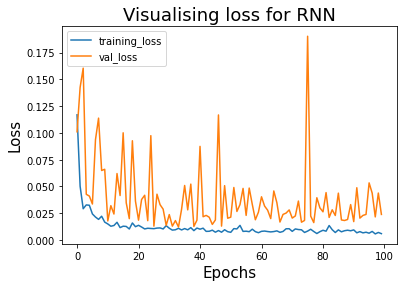

In [58]:
#plot for change in loss vs epochs
training_loss = val.history['loss']
val_loss = val.history['val_loss']

plt.plot(training_loss,label='training_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Visualising loss for RNN',fontsize=18)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.show()

In [59]:
# getting the test data
inputs=X[len(X)-len(test_data)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)    #standardizing

In [60]:
# preparing sample points for test data
x_test=[]
y_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
    y_test.append(inputs[i,0])
x_test=np.array(x_test)
y_test=np.array(y_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [61]:
pred = reg.predict(x_test)          #predicting on test data
rnn_pred=scaler.inverse_transform(pred)        #  inverse transform the standardizing for test sample

In [62]:
data_test=np.array(test_data)
data_test=data_test.reshape(len(data_test),1)

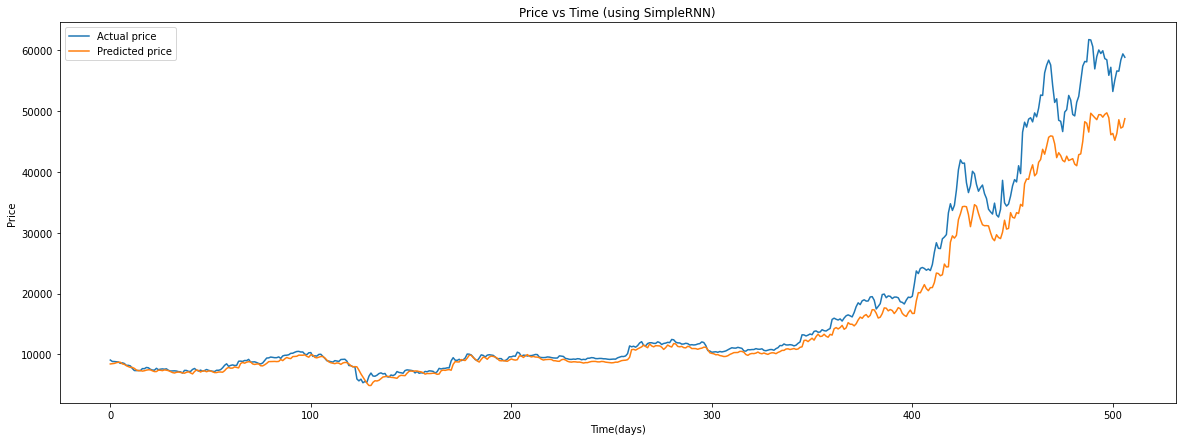

In [63]:
#plot the actual price vs rnn predicted price
plt.figure(figsize = (20,7))
plt.plot(data_test,'-')
plt.plot(rnn_pred,'-')
plt.xlabel('Time(days)')
plt.ylabel('Price')
plt.title('Price vs Time (using SimpleRNN)')
plt.legend(['Actual price', 'Predicted price'])
plt.show()

#### Disadvantages of RNN’s
- Gradient exploding and vanishing problems.
- Training an RNN is a completely tough task.
- It cannot system very lengthy sequences if the usage of Tanh or Relu as an activation feature.

It can be difficult to train standard RNNs to solve problems that require learning long-term temporal dependencies. This is because the gradient of the loss function decays exponentially with time (called the vanishing gradient problem).

This problem is solved by LSTM..

## Long Short Term Memory networks(LSTM):

LSTM networks are a type of RNN that uses special units in addition to standard units. LSTM units include a 'memory cell' that can maintain information in memory for long periods of time. A set of gates is used to control when information enters the memory, when it's output, and when it's forgotten. This architecture lets them learn longer-term dependencies.

We having following components in LSTM:

1. Forget gate:It decides what information should be thrown away or kept. It uses sigmoid function for it , the value closer to 0 means to forget, and the closer to 1 means to keep.

<img src='img/forget_gate.gif'/>


2. Input gate: It pass the previous hidden state and current input into a sigmoid function.It also pass the hidden state and current input into the tanh function to squish values between -1 and 1 to help regulate the network.Then you multiply the tanh output with the sigmoid output. The sigmoid output will decide which information is important to keep from the tanh output.

<img src='img/input_gate.gif'/>

3. Cell State: First, the cell state gets pointwise multiplied by the forget vector,it helps to drop values(same as we add dropout in NN ). Then it adds output of input and forget gate nad gives the new cell state for relavent NN.

<img src='img/cell_state.gif'/>

4. Output gate: It decides what the next hidden state should be,the hidden state contains information on previous inputs, the hidden state is also used for predictions,it perform the same thing as we done for output layer of RNN.


<img src='img/output_state.gif'/>

For understanding forward and backward propagation follow [here](https://towardsdatascience.com/only-numpy-deriving-forward-feed-and-back-propagation-in-long-short-term-memory-lstm-part-1-4ee82c14a652) and [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs)

In [64]:
#init lstm model 
lstm=Sequential()

lstm.add(LSTM(64,input_shape=(x_train.shape[1],1),activation="relu"))


lstm.add(Dense(1))


lstm.compile(loss="mean_squared_error",optimizer="adam")


hist=lstm.fit(x_train,y_train,epochs=100,batch_size=32,validation_split=0.1)

Epoch 1/100
80/80 [==============================] - 5s 51ms/step - loss: 0.3068 - val_loss: 0.1774
Epoch 2/100
80/80 [==============================] - 4s 53ms/step - loss: 0.0383 - val_loss: 0.0359
Epoch 3/100
80/80 [==============================] - 4s 50ms/step - loss: 0.0114 - val_loss: 0.0365
Epoch 4/100
80/80 [==============================] - 4s 47ms/step - loss: 0.0064 - val_loss: 0.0466
Epoch 5/100
80/80 [==============================] - 4s 54ms/step - loss: 0.0098 - val_loss: 0.0191
Epoch 6/100
80/80 [==============================] - 4s 56ms/step - loss: 0.0055 - val_loss: 0.0215
Epoch 7/100
80/80 [==============================] - 4s 50ms/step - loss: 0.0046 - val_loss: 0.0194
Epoch 8/100
80/80 [==============================] - 4s 53ms/step - loss: 0.0040 - val_loss: 0.0229
Epoch 9/100
80/80 [==============================] - 4s 49ms/step - loss: 0.0062 - val_loss: 0.0221
Epoch 10/100
80/80 [==============================] - 4s 53ms/step - loss: 0.0055 - val_loss: 0.0162

In [65]:
lstm.save('/model/timeseries_price_LSTM.h5')

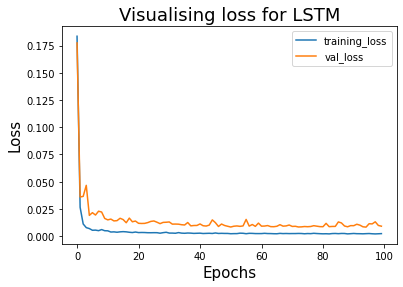

In [66]:
#plot loss for LSTM
training_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(training_loss,label='training_loss')
plt.plot(val_loss,label='val_loss') 
plt.legend()
plt.title('Visualising loss for LSTM',fontsize=18)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.show()

In [67]:
# inputs=X[len(X)-len(test_data)-timestep:]
# inputs=inputs.values.reshape(-1,1)
# inputs=scaler.transform(inputs)

In [68]:
# x_test=[]
# y_test=[]
# for i in range(timestep,inputs.shape[0]):
#     x_test.append(inputs[i-timestep:i,0])
#     y_test.append(inputs[i,0])
# x_test=np.array(x_test)
# y_test=np.array(y_test)
# x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [69]:
pred = lstm.predict(x_test)          #making prediction
lstm_pred=scaler.inverse_transform(pred)

In [70]:
# data_test=np.array(test_data)
# data_test=data_test.reshape(len(data_test),1)

In [71]:
print('MSE : ' + str(mean_squared_error(y_test, pred)))
rnn_score = r2_score(y_test,pred)
print("R2 Score of LSTM model = ",rnn_score)

MSE : 1.1326401964495325
R2 Score of LSTM model =  0.9291853167168119


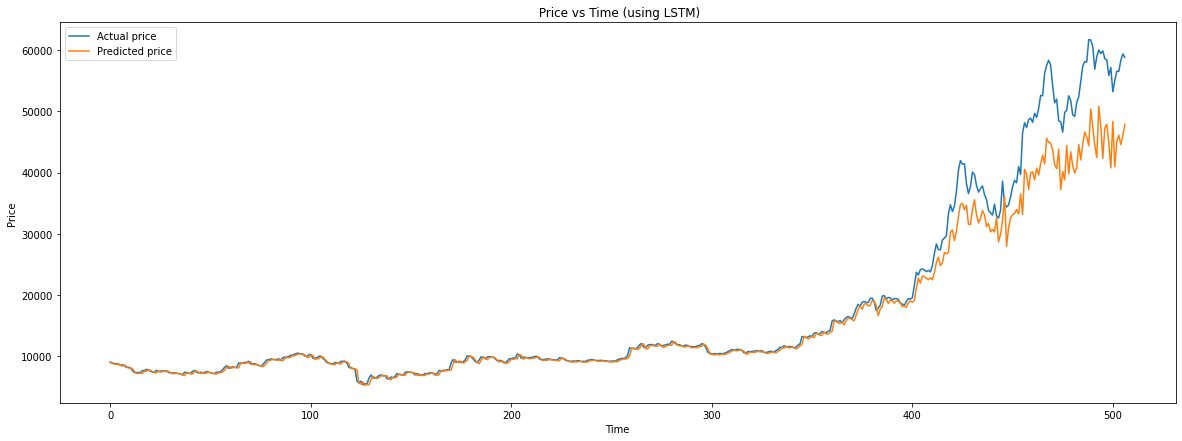

In [72]:
#plot actual value vs predicted value for LSTM
plt.figure(figsize = (20,7))
plt.plot(data_test,'-')
plt.plot(lstm_pred,'-')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(' Price vs Time (using LSTM)')
plt.legend(['Actual price', 'Predicted price'])
plt.show()

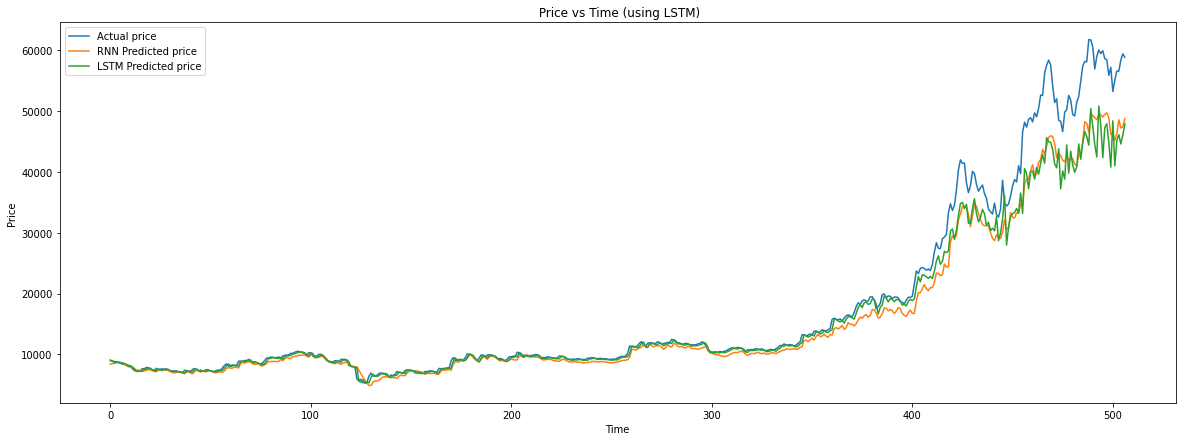

In [73]:
# plot actual vs predcited value by RNN vs predicted value by LSTM
plt.figure(figsize = (20,7))
plt.plot(data_test,'-',label='Actual price')
plt.plot(rnn_pred,'-',label='RNN Predicted price')
plt.plot(lstm_pred,'-',label='LSTM Predicted price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(' Price vs Time (using LSTM)')
plt.legend()
plt.show()

Now we will make prediction for next coming 30 days

In [121]:
prediction=x_test[-1]    ##taking the last 30 days datasets to predict data for next 30days

In [122]:
for i in range(30):  # looping for 30 days,to predict for next coming days
    kl=prediction[i:timestep+i].reshape(1,timestep,1)       
    prediction=np.append(prediction,lstm.predict(kl),axis=0)   ##append predicted data using previous 30 days

In [129]:
prediction=scaler.inverse_transform(prediction)

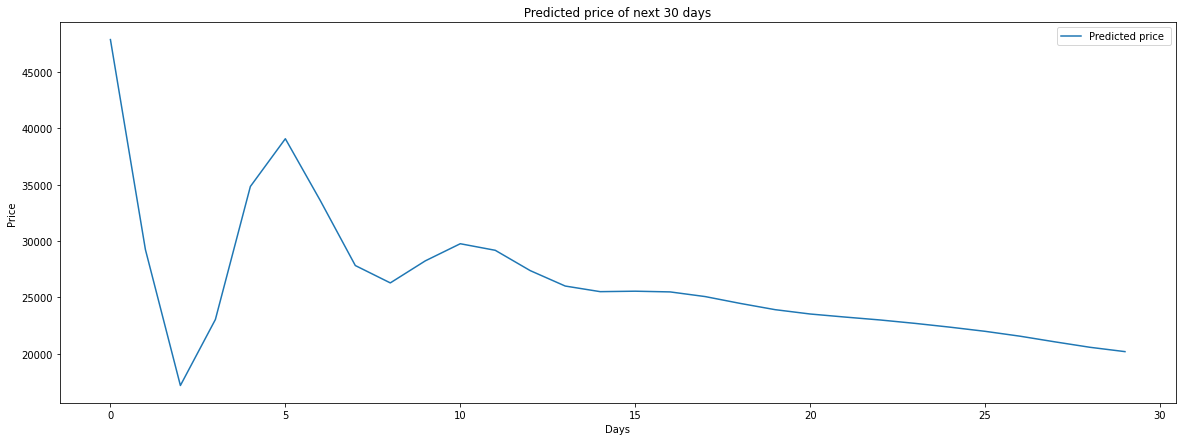

In [134]:
#plot price for coming 30 days
plt.figure(figsize = (20,7))
plt.plot(prediction[30:],'-',label='Predicted price ')

plt.xlabel('Days')
plt.ylabel('Price')
plt.title(' Predicted price of next 30 days ')
plt.legend()
plt.show()

The price of prediced next 30 days, but its decreasing , so market can up and down anytime .As LSTM is based on previous data ,it might be the case that the price on these days might went up but as we had predicted using past 30 days the prices  are decreasing. So one need to look after the market periodically to monitor the prices as it may went up or down , due many circumtances..

## Conclusion:
- If someone wants to trade in bitcoin then need to watch the prices on daily basis ,because the variation in price for down and up trend are in same proportion , so one need to look for square off for the price trades in order to make profit.
- The miner or the investor who had trade bitcoin during the year around 2014 or before 2014 would have more wealth now , because the volume was more and the prices were less,so they have make more profit percentage as compare to 2021.
- Highest price trades are made in 2021 ,but the avg. prices was still very less which shows most of the investors are not aggressive trader or who has fear of loss or less domain knowledge.
- The Avg. price volume was highest for 2021 and that is for the data of 3 months only ,which represents that even in quarter time we huge trade was occur this year and it may increases by the end of the year.
- The growth in prices in starting of 2021 is almost kind of exponential and some of the reports mentioned that it might hit 100K USD by end of year ,so if one wants to trade then he good profit could be made by end of the year.
- For a particular day the highest price and lowest price difference is almost negligible as compared to overall change in year or month,which shows those values have significant changes in prices after 24 hours.
- The best season to make profit from BTC is winter season , as price for bitcoin get increases for those period in the year. Investor should invest in mid year and sqaure off around new year to make good profit.
- In time series analysis, the exponential smoothing method predicts the next period value on the basis of the past value and the current value that why we use RNN,which feeding back output from previous state to the next input in order to memorize the past.
- RNN has gradient exploding,vanishing problems , it's difficult to train standard RNNs to solve problems that require learning long-term temporal dependencies.
- LSTM networks are a type of RNN that uses special units in addition to standard units and address the drawback of RNN.
- From the last graph we can see that LSTM has better prediction and loss descent than RNN and LSTM also uses less NN to train model in comparison to RNN.  